## Step 3: Attemt to build model on "original" images using bout MobileNetV3Small

About MobileNetV3Small:
- https://arxiv.org/pdf/1905.02244
- https://aihub.qualcomm.com/models/mobilenet_v3_small

In [41]:
import os
import pathlib
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
from tensorflow.keras import layers, losses, optimizers, applications, models
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import mixed_precision

os.environ["CUDA_VISIBLE_DEVICES"]="-1"    


# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [42]:
# constants

SEED = 7000
image_size = (256, 256)
image_shape = image_size + (3,)

BATCH_SIZE = 32

path = "./data/crop/"
data_dir = pathlib.Path(path)

In [43]:
# Splitting full dataset to testing and training

print('Train data')
train_df = image_dataset_from_directory(data_dir,
                                          validation_split=0.3,
                                          subset='training',
                                          seed=SEED,
                                          shuffle=True,
                                          image_size=image_size,
                                          interpolation='bilinear',
                                          color_mode='rgb',
                                          batch_size=BATCH_SIZE
                                          )
train_df
print('\nValidation data')
validation_df = image_dataset_from_directory(data_dir,
                                               validation_split=0.3,
                                               subset='validation',
                                               shuffle = True,       
                                               seed=SEED,
                                               image_size=image_size,
                                               interpolation='bilinear',
                                               color_mode='rgb',
                                               batch_size=BATCH_SIZE)

validation_df

print('\nTraining dataset: ' + str(train_df))
print('There is {} images in the training dataset'.format(len(train_df)))
print('Validation dataset: ' + str(validation_df))
print('There is {} images in the validation dataset'.format(len(validation_df)))

Train data
Found 27564 files belonging to 60 classes.
Using 19295 files for training.

Validation data
Found 27564 files belonging to 60 classes.
Using 8269 files for validation.

Training dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
There is 603 images in the training dataset
Validation dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
There is 259 images in the validation dataset


In [44]:
def preprocess_image(image, label):

    # just extention point 
    
    return image, label
    
def preprocess_image_train(image, label):
    
    # apply_data_augmentation
    
    # Random rotation
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Random flip
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.1)
    
    # Random contrast
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    
    # Ensure the image values are still in the valid range
    # image = tf.clip_by_value(image, 0.0, 1.0)
    
    # Ensure the output is in float32 format
    image = tf.cast(image, tf.float32)
    
    return image, label

In [45]:
# prefetch() function is used to produce a dataset that prefetches the specified elements from this given dataset. 
# It accepts a bufferSize parameter. 
# It is an integer value that specifies the number of elements to be prefetched

# Apply preprocessing and augmentation for the traing data
train_ds = train_df.map(preprocess_image_train, num_parallel_calls=tf.data.AUTOTUNE)

# # Apply ONLY preprocessing for the validation data
validation_ds = validation_df.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

2024-08-05 14:42:23.594296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [19295]
	 [[{{node Placeholder/_0}}]]
2024-08-05 14:42:23.594484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [19295]
	 [[{{node Placeholder/_4}}]]


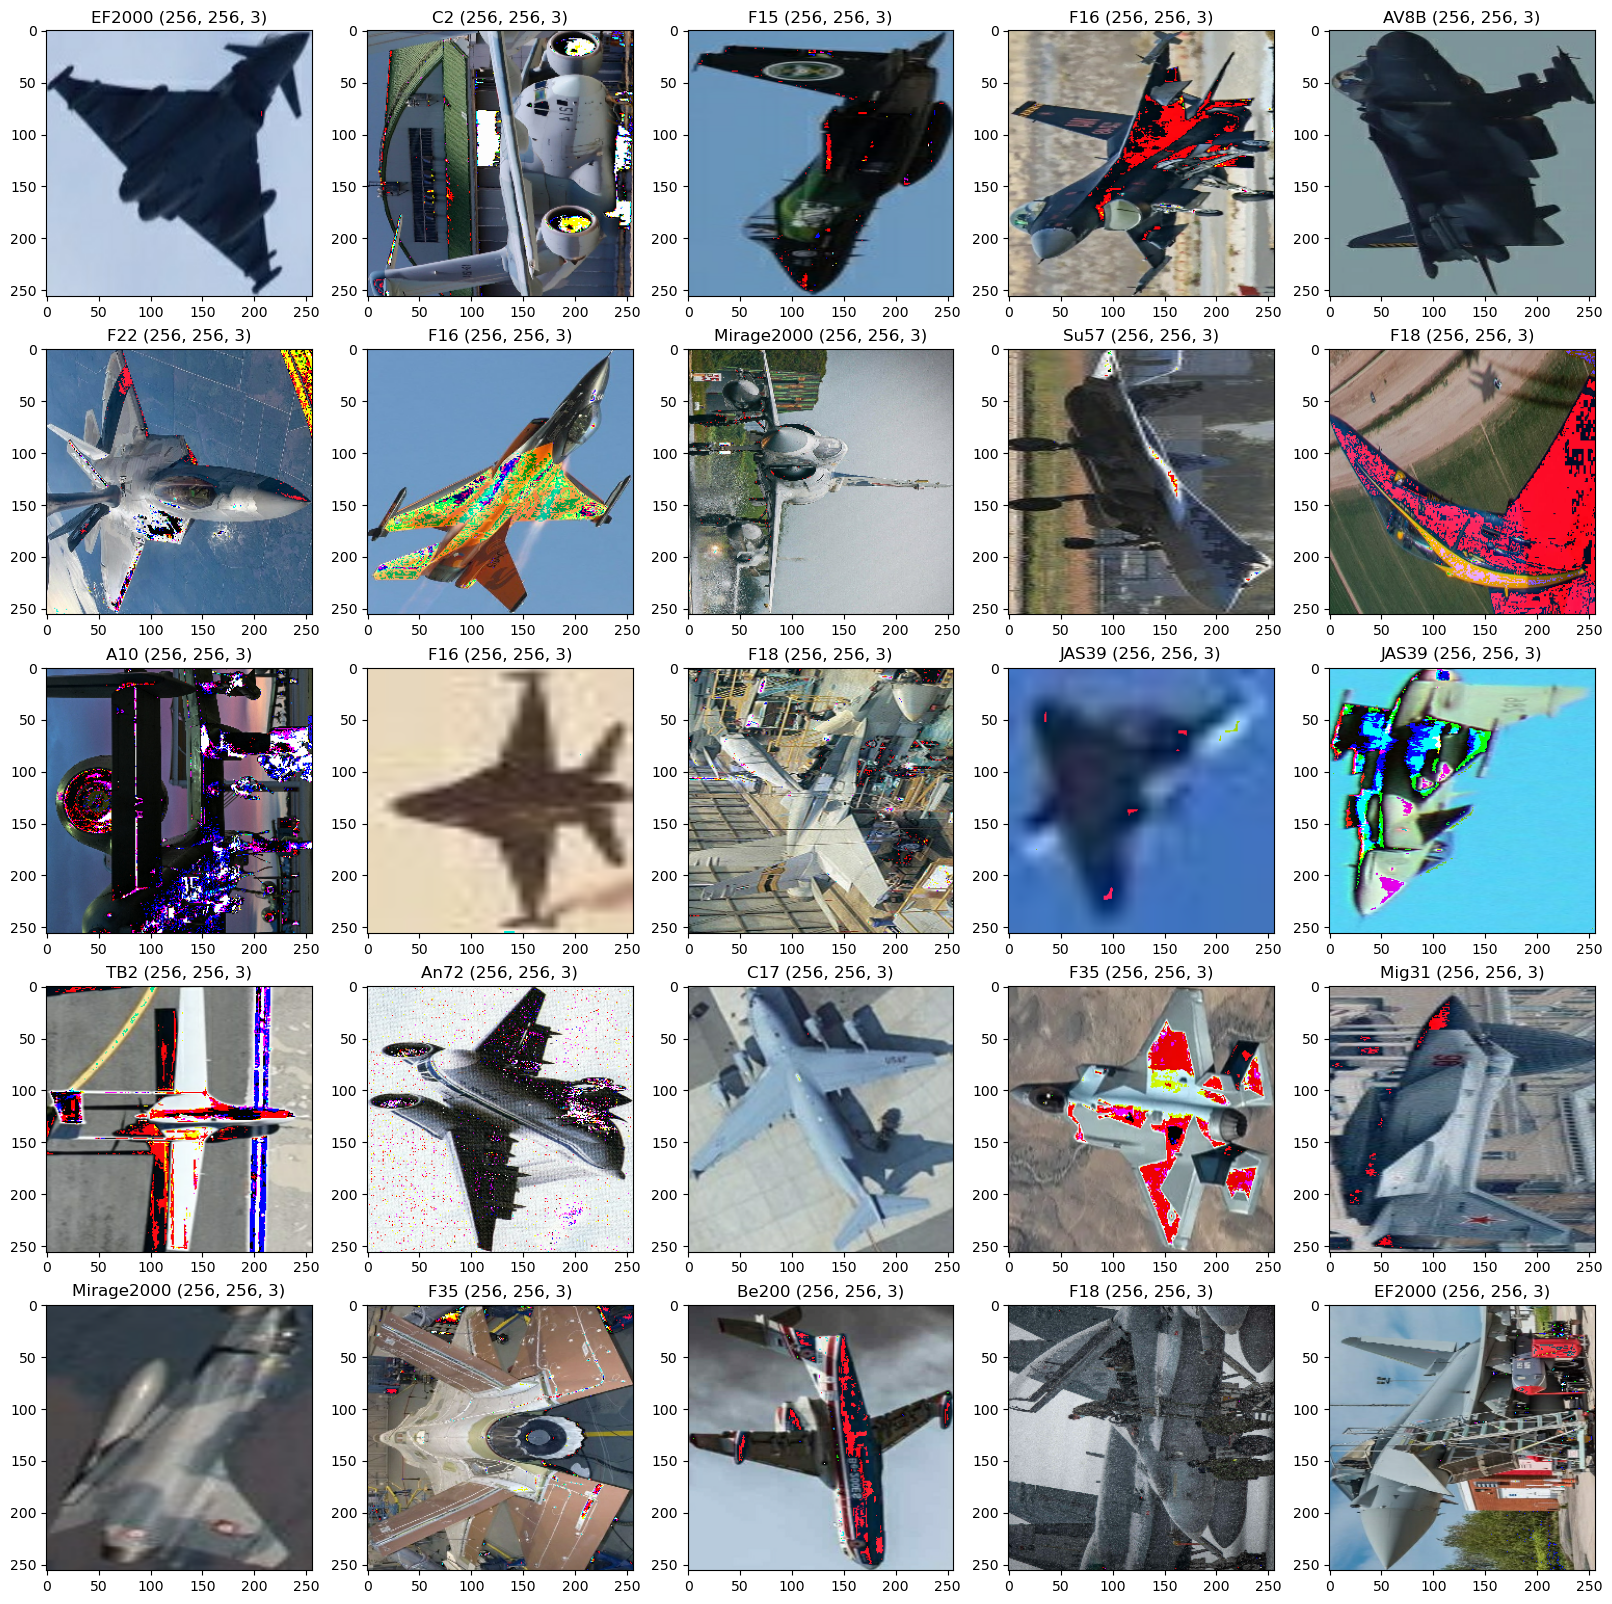

In [46]:
class_names = train_df.class_names

def plot_images_from_df(ds, class_names):
    plt.figure(figsize = (20, 20))
    for images, labels in ds.take(1):
        for i in range(25):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]] + " " + str(images[i].shape))

plot_images_from_df(train_ds, class_names)

## Attempt to use MobileNetV2 as the base model

In [58]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
model2 = models.Sequential([    
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])


model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    # optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 256)               327936    
                                                                 
 batch_normalization_10 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                      

In [59]:
# Train the model
epochs2 = 15

early_stop2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history2 = model2.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs2,
    callbacks=[early_stop2, lr_scheduler]
)

Epoch 1/15
 35/603 [>.............................] - ETA: 9:57 - loss: 4.6862 - accuracy: 0.0402

KeyboardInterrupt: 

In [ ]:
# persist model
model2.save_weights('./MobileNetV2_weights.h5')

# Evaluate the model
test_loss, test_accuracy = model2.evaluate(validation_ds)
print(f"Test accuracy: {test_accuracy:.2f}")

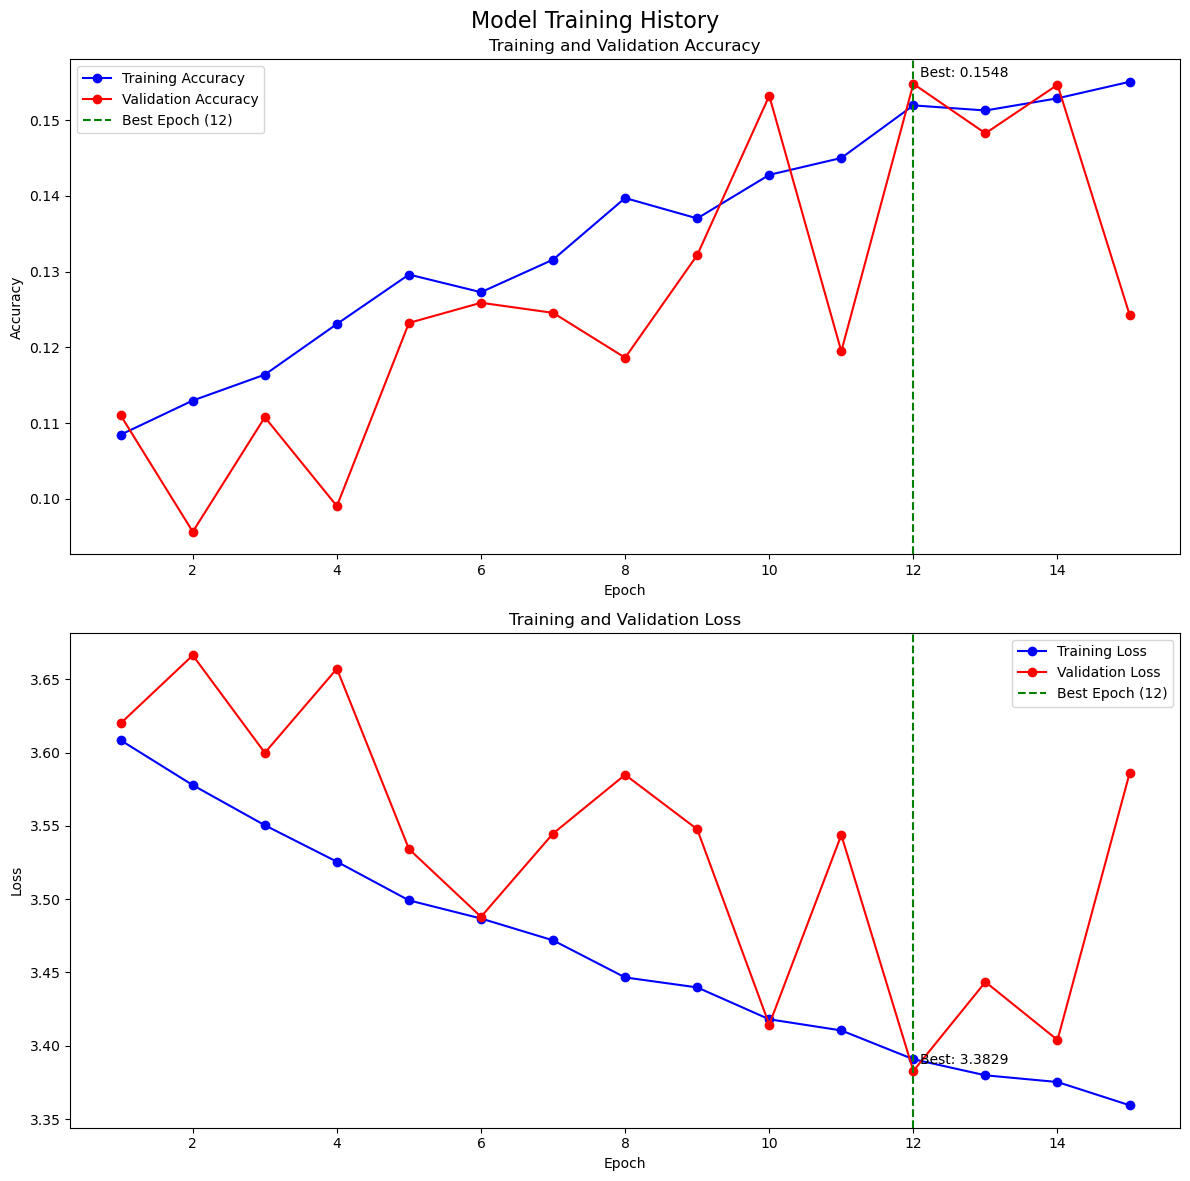

Best Validation Accuracy: 0.1548 at epoch 12
Best Validation Loss: 3.3829 at epoch 12


In [54]:
def plot_training_history(history):
    # Extract history data
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Find best epochs
    best_acc_epoch = val_acc.index(max(val_acc)) + 1
    best_loss_epoch = val_loss.index(min(val_loss)) + 1

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    fig.suptitle('Model Training History', fontsize=16)

    # Plot accuracy
    ax1.plot(epochs, acc, 'bo-', label='Training Accuracy')
    ax1.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    ax1.axvline(x=best_acc_epoch, color='g', linestyle='--', label=f'Best Epoch ({best_acc_epoch})')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Add text annotation for best accuracy
    best_val_acc = max(val_acc)
    ax1.annotate(f'Best: {best_val_acc:.4f}', 
                 xy=(best_acc_epoch, best_val_acc),
                 xytext=(5, 5), textcoords='offset points')

    # Plot loss
    ax2.plot(epochs, loss, 'bo-', label='Training Loss')
    ax2.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    ax2.axvline(x=best_loss_epoch, color='g', linestyle='--', label=f'Best Epoch ({best_loss_epoch})')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Add text annotation for best loss
    best_val_loss = min(val_loss)
    ax2.annotate(f'Best: {best_val_loss:.4f}', 
                 xy=(best_loss_epoch, best_val_loss),
                 xytext=(5, 5), textcoords='offset points')

    plt.tight_layout()
    plt.show()

    print(f"Best Validation Accuracy: {best_val_acc:.4f} at epoch {best_acc_epoch}")
    print(f"Best Validation Loss: {best_val_loss:.4f} at epoch {best_loss_epoch}")

plot_training_history(history2)

## TODO: learn the same model as for grayscale first (to compare)

In [33]:
# Attempt to reuse model that was created on step 2 - changed only input shape coz images has 3 channels

class_names = train_df.class_names

num_classes = len(class_names)

def create_lightweight_model():
    model = models.Sequential([
        layers.Input(shape=(256, 256, 3)),
        layers.SeparableConv2D(8, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0025)),
        layers.BatchNormalization(epsilon= 0.01),
        layers.MaxPooling2D(),
        layers.SeparableConv2D(16, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0025)),
        layers.BatchNormalization(epsilon= 0.01),
        layers.MaxPooling2D(),
        layers.SeparableConv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
        layers.BatchNormalization(epsilon= 0.01),
        layers.MaxPooling2D(),
        layers.SeparableConv2D(48, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
        layers.BatchNormalization(epsilon= 0.01),
        layers.MaxPooling2D(),
        layers.SeparableConv2D(64, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
        layers.BatchNormalization(epsilon= 0.01),
        layers.MaxPooling2D(),
        # layers.Flatten(),
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(epsilon= 0.01),
        layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dropout(0.25),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Create and compile the model
model = create_lightweight_model()


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separable  (None, 254, 254, 8)      59        
 Conv2D)                                                         
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 8)      0         
 )                                                               
                                                                 
 separable_conv2d_1 (Separab  (None, 125, 125, 16)     216       
 leConv2D)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 16)     6

In [34]:
# Configure for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# callbacks
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# Learning rate schedule
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

In [35]:
# Train the model
epochs = 50
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/50


2024-08-05 13:22:09.018092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [19295]
	 [[{{node Placeholder/_4}}]]
2024-08-05 13:22:09.018299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [19295]
	 [[{{node Placeholder/_0}}]]
2024-08-05 13:22:19.693032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 135 of 1000
2024-08-05 13:22:29.666069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 278 of 1000
2024-08-05 13

603/603 [==============================] - ETA: 0s - loss: 4.2254 - accuracy: 0.0566

2024-08-05 13:25:34.167159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [8269]
	 [[{{node Placeholder/_4}}]]
2024-08-05 13:25:34.167788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [8269]
	 [[{{node Placeholder/_4}}]]
2024-08-05 13:25:45.184031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 146 of 1000
2024-08-05 13:25:50.884698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


603/603 [==============================] - 243s 334ms/step - loss: 4.2254 - accuracy: 0.0566 - val_loss: 3.9585 - val_accuracy: 0.0608 - lr: 0.0010
Epoch 2/50
343/603 [================>.............] - ETA: 1:29 - loss: 3.8823 - accuracy: 0.0765

Exception ignored in: <function UniquePtr.__del__ at 0x135df1f70>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/cv/lib/python3.8/site-packages/tensorflow/python/framework/c_api_util.py", line 70, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: 